In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def calculate_eddy(width=500000, num_depth_layers=21, eta0=1, L=1e5, H=1000, a=1, b=1, rho0=1025, 
                                            f0=None, alpha_1=0., alpha_2=0., T0=20, dTdz=0.005, dSdz=0.01, taper_depth=None):
    """
    Calculate the 3D geostrophic velocity components U, V, density anomaly sigma, temperature, salinity, 
    and pressure fields for an ocean eddy.

    Parameters:
    - width: Horizontal extent of the grid (eddy scale) in meters.
    - num_depth_layers: Number of vertical layers (depth resolution).
    - eta0: Surface elevation perturbation.
    - L: Horizontal length scale of the eddy in meters.
    - H: Vertical depth scale of the eddy in meters.
    - a, b: Coefficients affecting density anomaly variation.
    - rho0: Reference density (kg/m^3).
    - f0: Coriolis parameter. If None, it will be calculated based on a latitude of -34 degrees.
    - alpha_1, alpha_2: Coefficients affecting eddy center shift with depth.
    - T0: Surface temperature (degrees Celsius).
    - dTdz: Temperature gradient with depth (degrees Celsius per meter).
    - dSdz: Salinity gradient with depth (psu per meter).
    - taper_depth: Tapering scale for vertical variations.

    Returns:
    - U, V: 3D matrices for the U and V (x- and y-components) velocity fields.
    - sigma: 3D matrix for the density anomaly.
    - T: 3D matrix for the temperature field.
    - S: 3D matrix for the salinity field.
    - P: 3D matrix for the pressure field.
    - x, y, z: Horizontal and vertical grid points.
    """
    # Constants
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))  # Coriolis parameter for latitude -34 degrees
    g = 9.81  # Gravitational acceleration (m/s^2)
    # Create 2D meshgrid for horizontal space (x, y) and depth (z)
    x = np.linspace(-width // 2, width // 2, 101)  # x-coordinates
    y = np.linspace(-width // 2, width // 2, 101)  # y-coordinates
    z = np.linspace(-H, 0, num_depth_layers)  # Depth levels from surface (0) to -H
    # Create 3D meshgrid
    x_3d, y_3d, z_3d = np.meshgrid(x, y, z, indexing='ij')
    if taper_depth is None:
        taper_factor = np.ones_like(z_3d)
    else:
        taper_factor = np.exp(z_3d / taper_depth)
    # Define the functions f(|r - r_c(z)|) and g(z)
    def f_r_rc(r, L):
        return np.exp(-r**2 / L**2)
    # Calculate the center position as a function of depth
    x_c = alpha_1 * z_3d
    y_c = alpha_2 * z_3d
    # Calculate radial distance r - r_c(z)
    r_c = np.hypot( x_3d - x_c, y_3d - y_c )
    # Temperature field
    # T = T0 + dTdz * z_3d - 2 * f_r_rc(r_c, L) * taper_factor
    T = - 2 * f_r_rc(r_c, L) * taper_factor
    # Salinity field
    S0 = 35  # Reference surface salinity (psu)
    # S = S0 + dSdz * z_3d + 1.5 * f_r_rc(r_c, L) * taper_factor
    S = 1.5 * f_r_rc(r_c, L) * taper_factor
    # Pressure field (hydrostatic pressure)
    P = -rho0 * g * z_3d
    # Density field using a simplified equation of state
    alpha = 0.0002  # Thermal expansion coefficient (1/°C)
    beta = 0.0008  # Haline contraction coefficient (1/psu)
    sigma = rho0 * (1 - alpha * (T - T0) + beta * (S - S0)) 
    sigma -= np.mean(sigma)
    # Calculate geostrophic velocity components
    dx = x[1] - x[0]  # Grid spacing in x
    dy = y[1] - y[0]  # Grid spacing in y
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy
    U = g / f0 * d_sigma_dy * taper_factor
    V = -g / f0 * d_sigma_dx * taper_factor

    U = np.flip(U, axis=2)
    V = np.flip(V, axis=2)
    sigma = np.flip(sigma, axis=2)
    T = np.flip(T, axis=2)
    S = np.flip(S, axis=2)
    P = np.flip(P, axis=2)
    z = np.flip(z)

    return U, V, sigma, T, S, P, x, y, z

In [3]:
def nencioli(u, v, lon, lat, a, b): #,var
    """
    Returns:
    - eddy_uv: Positions that satisfy the first two constraints (for debugging)
    - eddy_c: Positions satisfying the first three constraints (for debugging)
    - eddy: Positions of the eddy centers with their type (cyclonic=1, anticyclonic=-1)
    """
    borders = max(a, b) + 1
    # Compute velocity magnitude
    vel = np.sqrt(u**2 + v**2)
    # Initialize arrays for storing eddy centers
    eddy_uv = np.zeros((0, 2))
    eddy_c = np.zeros((0, 2))
    eddy = np.zeros((0, 3))
    # Get domain dimensions
    bound = vel.shape
    # Loop through each latitudinal section
    for i in range(borders, len(v) - borders + 1):
        wrk = v[i, :]  # Latitudinal section of v
        # First constraint: zero crossing in v component
        s = np.sign(wrk)
        indx = np.where(np.diff(s) != 0)[0]
        indx = indx[(indx >= borders) & (indx < len(wrk) - borders)]
        for ii in indx:
            var = 0  # Eddy type (0 = no eddy, 1 = cyclonic, -1 = anticyclonic)
            if wrk[ii] >= 0:  # Anticyclonic
                if wrk[ii - a] > wrk[ii] and wrk[ii + 1 + a] < wrk[ii + 1]:
                    var = -1
            elif wrk[ii] < 0:  # Cyclonic
                if wrk[ii - a] < wrk[ii] and wrk[ii + 1 + a] > wrk[ii + 1]:
                    var = 1
            # Second constraint: u component reversal
            if var != 0:
                if var == -1:
                    if (u[i - a, ii] <= 0 and u[i - a, ii] <= u[i - 1, ii] and
                        u[i + a, ii] >= 0 and u[i + a, ii] >= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0
                elif var == 1:
                    if (u[i - a, ii] >= 0 and u[i - a, ii] >= u[i - 1, ii] and
                        u[i + a, ii] <= 0 and u[i + a, ii] <= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0
                # Third constraint: velocity minimum
                if var != 0:
                    srch = vel[i - b:i + b, ii - b:ii + b + 1]
                    slat = lat[i - b:i + b, ii - b:ii + b + 1]
                    slon = lon[i - b:i + b, ii - b:ii + b + 1]
                    X, Y = np.unravel_index(np.argmin(srch), srch.shape)
                    srch2 = vel[max(i - b + X - 1 - b, 0):min(i - b + X - 1 + b, bound[0]),
                                max(ii - b + Y - 1 - b, 0):min(ii - b + Y - 1 + b, bound[1])]

                    if np.min(srch2) == np.min(srch):
                        eddy_c = np.vstack([eddy_c, [slat[X, Y], slon[X, Y]]])
                    else:
                        var = 0
                # Fourth constraint: vector rotation (simplified version)
                d = a - 1
                if var != 0:
                    # Find indices of the estimated center in the large domain
                    i1, i2 = np.where((lat == slat[X, Y]) & (lon == slon[X, Y]))
                    i1, i2 = int(i1[0]), int(i2[0])
                    # Extract velocities within "a-1" points from the estimated center
                    u_small = u[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    v_small = v[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    # Apply constraint only if there are no NaNs in u_small
                    if not np.isnan(u_small).any():
                        # Boundary velocities
                        u_bound = np.concatenate([u_small[0, :], u_small[1:, -1], u_small[-1, -2::-1], u_small[-2::-1, 0]])
                        v_bound = np.concatenate([v_small[0, :], v_small[1:, -1], v_small[-1, -2::-1], v_small[-2::-1, 0]])
                        # Vector defining which quadrant each boundary vector belongs to
                        quadrants = np.zeros_like(u_bound)
                        quadrants[(u_bound >= 0) & (v_bound >= 0)] = 1
                        quadrants[(u_bound < 0) & (v_bound >= 0)] = 2
                        quadrants[(u_bound < 0) & (v_bound < 0)] = 3
                        quadrants[(u_bound >= 0) & (v_bound < 0)] = 4
                        # Identify the first fourth quadrant vector
                        spin = np.where(quadrants == 4)[0]
                        # Apply the constraint only if the rotation is complete and not all vectors are in the fourth quadrant
                        if spin.size > 0 and spin.size != quadrants.size:
                            # If vectors start in the 4th quadrant, add 4 to all quadrant positions after the first occurrence
                            if spin[0] == 0:
                                spin = np.where(quadrants != 4)[0]
                                spin = spin[0] - 1
                            if not isinstance(spin, np.ndarray):
                                spin = np.array([int(spin)])
                            quadrants[spin[-1] + 1:] += 4
                            # Inspect vector rotation: no consecutive vectors should be more than one quadrant apart
                            # and there should be no backward rotation
                            if not np.any(np.diff(quadrants) > 1) and not np.any(np.diff(quadrants) < 0):
                                eddy = np.vstack([eddy, [slat[X, Y], slon[X, Y], var]])
    # Process eddy results (sorting and removing duplicates)
    eddy = np.unique(eddy, axis=0)
    eddy_uv = np.unique(eddy_uv, axis=0)
    eddy_c = np.unique(eddy_c, axis=0)
    # Adjust for the Southern Hemisphere (flip cyclonic/anticyclonic labels)
    eddy[:, 2] = -eddy[:, 2]

    return eddy_uv, eddy_c, eddy

In [4]:
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=None)

U_tap, V_tap, sigma_tap, T_tap, S_tap, P_tap, _, _, _ = calculate_eddy(taper_depth=400)

dx, dy, dz = x[1] - x[0], y[1] - y[0], z[1]-z[0]

alpha_1 = dx / dz # tilt in x direction

U_tilt, V_tilt, sigma_tilt, T_tilt, S_tilt, P_tilt, _, _, _ = calculate_eddy(taper_depth=None, alpha_1=alpha_1)

U_tilt_tap, V_tilt_tap, sigma_tilt_tap, T_tilt_tap, S_tilt_tap, P_tilt_tap, _, _, _ = calculate_eddy(taper_depth=400, alpha_1=alpha_1)

In [5]:
modelled_data = {
    'Eddy0':{
        'Name': 'E1', 'U': U, 'V': V, 'sigma': sigma, 'T': T, 'S': S, 'P': P
    },
    'Eddy1':{
        'Name': r'E1$_\text{tap}$', 'U': U_tap, 'V': V_tap, 'sigma': sigma_tap, 'T': T_tap, 'S': S_tap, 'P': P_tap
    },
    'Eddy2':{
        'Name': 'E2', 'U': U_tilt, 'V': V_tilt, 'sigma': sigma_tilt, 'T': T_tilt, 'S': S_tilt, 'P': P_tilt
    },
    'Eddy3':{
        'Name': r'E2$_\text{tap}$', 'U': U_tilt_tap, 'V': V_tilt_tap, 'sigma': sigma_tilt_tap, 'T': T_tilt_tap, 'S': S_tilt_tap, 'P': P_tilt_tap
    },
    'x': x, 'y': y, 'z': z
}
eddies = ['Eddy0', 'Eddy1', 'Eddy2', 'Eddy3']

In [6]:
result_data = pd.DataFrame(columns=['Eddy', 'z', 'nic', 'njc', 'nxc', 'nyc', 'xc', 'yc', 'Depth', 'Vort', 'r1', 'r2', 'r3', 'r4'])

x, y = modelled_data['x'], modelled_data['y']
dx = x[1] - x[0]
X, Y = np.meshgrid(x, y)
var = 1
plot_data = {}

for eddy in eddies:

    plot_data[eddy] = {}
    U, V = modelled_data[eddy]['U'], modelled_data[eddy]['V']
    xc_pre, yc_pre = 0, 0

    for depth_lvl in range(U.shape[-1]):

        # Find nencioli
        u, v = U[:, :, depth_lvl], V[:, :, depth_lvl]
        neddy = nencioli(u.T, v.T, X, Y, 4, 3)[2]
        neddy = neddy[neddy[:, 2] == var]
        
        if len(neddy[:, 1]) > 1:
            R = np.hypot(xc_pre - neddy[:, 1], yc_pre - neddy[:, 0])
            neddy = neddy[R == np.nanmin(R)]
        elif len(neddy[:, 1]) == 0:
            break
        
        nxc, nyc = neddy[0, 1], neddy[0, 0]
        nic, njc = np.where(nxc == x)[0][0], np.where(nyc == y)[0][0]
        
        # Fit cubic and tangent
        def fit_cubic_and_tangent(x, y):
            cubic = np.poly1d(np.polyfit(x, y, 3))
            cubic_deriv = np.polyder(cubic)
            roots = np.roots(cubic)
            valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
        
            if valid_roots.size:
                R = np.abs(valid_roots-x[len(x)//2])
                root = valid_roots[R==np.min(R)][0]
                slope = cubic_deriv(root)
                intercept = -slope * root
            else:
                slope = 0
                roots = np.roots(cubic_deriv)
                valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
                if valid_roots.size:
                    R = np.abs(valid_roots-x[len(x)//2])
                    root = valid_roots[R==np.min(R)]
                    intercept = cubic(root)
                else:
                    intercept = np.mean(y)
    
            sst = np.sum((y - np.mean(y))**2)
            sse = np.sum((y - cubic(x))**2)  # Use cubic(x) instead of tangent_line
    
            r_squared = 1 if (sst == 0 and sse == 0) else 1 - (sse / sst)
                
            return slope, intercept, r_squared

        def optimal_cubic_domain(l, vel, ic, r_min=20, r_max=30):
    
            def min_distance_from_index_to_nan_1d(arr, ic):
                from scipy.ndimage import distance_transform_edt
                mask = np.isnan(arr)
                distances = distance_transform_edt(~mask)
                return int(distances[ic] - 1)
                
            r_compulsory_min = min_distance_from_index_to_nan_1d(vel, ic)
    
            if r_compulsory_min < r_min:
                if r_compulsory_min > 3:
                    r_min = r_compulsory_min
                else:
                    return None, None, None, None, None
    
            results = []
        
            for r1 in range(r_min, r_max + 1):
                for r2 in range(r_min, r_max + 1):
                    i_min, i_max = max(0, ic - r1), min(len(vel), ic + r2 + 1)
        
                    vel_cut = vel[i_min:i_max]
                    l_cut = l[i_min:i_max]
                    if np.any(np.isnan(vel_cut)): # another r will work
                        E1, E0, r2E = np.nan, np.nan, np.nan
                    else:
                        mask = ~np.isnan(vel_cut)
                        vel_cut = vel_cut[mask]
                        l_cut = l_cut[mask] / 1000
    
                        E1, E0, r2E = fit_cubic_and_tangent(l_cut, vel_cut)
            
                    results.append((r1, r2, E1, E0, r2E))
        
            df = pd.DataFrame(results, columns=['r1', 'r2', 'Slope', 'Int', 'R2'])

            if df.isna().all().all():
                return None, None, None, None, None
        
            optimal_domain = df.loc[df['R2']==np.nanmax(df['R2'])].iloc[-1]
    
            return optimal_domain['Slope'], optimal_domain['Int'], optimal_domain['R2'], optimal_domain['r1'], optimal_domain['r2']

        u1, v1 = u[:, njc], v[:, njc]
        u2, v2 = u[nic, :], v[nic, :]

        B1, B0, r2B, r1, r2 = optimal_cubic_domain(x, v1, nic)
        if B1 == None:
            break
        C1, C0, r2C, r3, r4 = optimal_cubic_domain(y, u2, njc)
        if C1 == None:
            break

        i_min, i_max = int(max(0, nic - r1)), int(min(len(u1), nic + r2))
        u1, v1 = u1[i_min:i_max], v1[i_min:i_max]
        xx = x[i_min:i_max]/1000
        A1, A0, r2A = fit_cubic_and_tangent(xx, u1)

        j_min, j_max = int(max(0, njc - r3)), int(min(len(u2), njc + r4))
        u2, v2 = u2[j_min:j_max], v2[j_min:j_max]
        yy = y[j_min:j_max]/1000
        D1, D0, r2D = fit_cubic_and_tangent(yy, v2)

        alpha = A0 if r2A > r2C else C0
        beta = B0 if r2B > r2D else D0
        gamma = A1 if r2A > r2D else -D1
        q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
                    
        yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))
        xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))
        w = 2 * (q11 + q22)

        # VORT_THRESH = 0.006
        R = np.hypot(xc - xc_pre, yc - yc_pre)
        # if np.abs(w) > VORT_THRESH and R < 100:
        if R < 100:
            result_data.loc[len(result_data)] = {
                'Eddy': eddy,
                'z': depth_lvl,
                'nic': nic,
                'njc': njc,
                'nxc': nxc/1000,
                'nyc': nyc/1000,
                'xc': xc,
                'yc': yc,
                'Depth': z[depth_lvl],
                'Vort': w,
                'r1': r1,
                'r2': r2,
                'r3': r3,
                'r4': r4
            }
            xc_pre, yc_pre = xc, yc
            plot_data[eddy][f'x{depth_lvl}'] = xx
            plot_data[eddy][f'y{depth_lvl}'] = yy
            plot_data[eddy][f'u1_{depth_lvl}'] = u1
            plot_data[eddy][f'u2_{depth_lvl}'] = u2
            plot_data[eddy][f'v1_{depth_lvl}'] = v1
            plot_data[eddy][f'v2_{depth_lvl}'] = v2
        else:
            break

In [7]:
result_data

,Eddy,z,nic,njc,nxc,nyc,xc,yc,Depth,Vort,r1,r2,r3,r4
0,Eddy0,0,50,50,0.0,0.0,4.064229e-15,4.064229e-15,0.0,-0.072028,20.0,20.0,20.0,20.0
1,Eddy0,1,50,50,0.0,0.0,4.064229e-15,4.064229e-15,-50.0,-0.072028,20.0,20.0,20.0,20.0
2,Eddy0,2,50,50,0.0,0.0,4.064229e-15,4.064229e-15,-100.0,-0.072028,20.0,20.0,20.0,20.0
3,Eddy0,3,50,50,0.0,0.0,4.064229e-15,4.064229e-15,-150.0,-0.072028,20.0,20.0,20.0,20.0
4,Eddy0,4,50,50,0.0,0.0,4.064229e-15,4.064229e-15,-200.0,-0.072028,20.0,20.0,20.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,Eddy3,16,66,50,80.0,0.0,8.000000e+01,4.314711e-15,-800.0,-0.001319,20.0,20.0,20.0,20.0
80,Eddy3,17,67,50,85.0,0.0,8.500000e+01,4.155149e-15,-850.0,-0.001027,20.0,20.0,20.0,20.0
81,Eddy3,18,68,50,90.0,0.0,9.000000e+01,4.192034e-15,-900.0,-0.000800,20.0,20.0,20.0,20.0
82,Eddy3,19,69,50,95.0,0.0,9.500000e+01,2.691339e-15,-950.0,-0.000623,20.0,20.0,20.0,20.0


In [8]:
eddy = 'Eddy1'

df = result_data[result_data['Eddy'] == eddy].drop(columns='Eddy').set_index('z')
df

,nic,njc,nxc,nyc,xc,yc,Depth,Vort,r1,r2,r3,r4
z,,,,,,,,,,,,
0,50,50,0.0,0.0,4.064229e-15,4.064229e-15,0.0,-0.072028,20.0,20.0,20.0,20.0
1,50,50,0.0,0.0,3.537033e-15,3.537033e-15,-50.0,-0.056095,20.0,20.0,20.0,20.0
2,50,50,0.0,0.0,4.169375e-15,4.169375e-15,-100.0,-0.043687,20.0,20.0,20.0,20.0
3,50,50,0.0,0.0,3.967388e-15,3.967388e-15,-150.0,-0.034023,20.0,20.0,20.0,20.0
4,50,50,0.0,0.0,4.296336e-15,4.296336e-15,-200.0,-0.026498,20.0,20.0,20.0,20.0
5,50,50,0.0,0.0,3.940432e-15,3.940432e-15,-250.0,-0.020636,20.0,20.0,20.0,20.0
6,50,50,0.0,0.0,5.261999e-15,5.261999e-15,-300.0,-0.016072,20.0,20.0,20.0,20.0
7,50,50,0.0,0.0,3.183370e-15,3.183370e-15,-350.0,-0.012517,20.0,20.0,20.0,20.0
8,50,50,0.0,0.0,4.004109e-15,4.004109e-15,-400.0,-0.009748,20.0,20.0,20.0,20.0


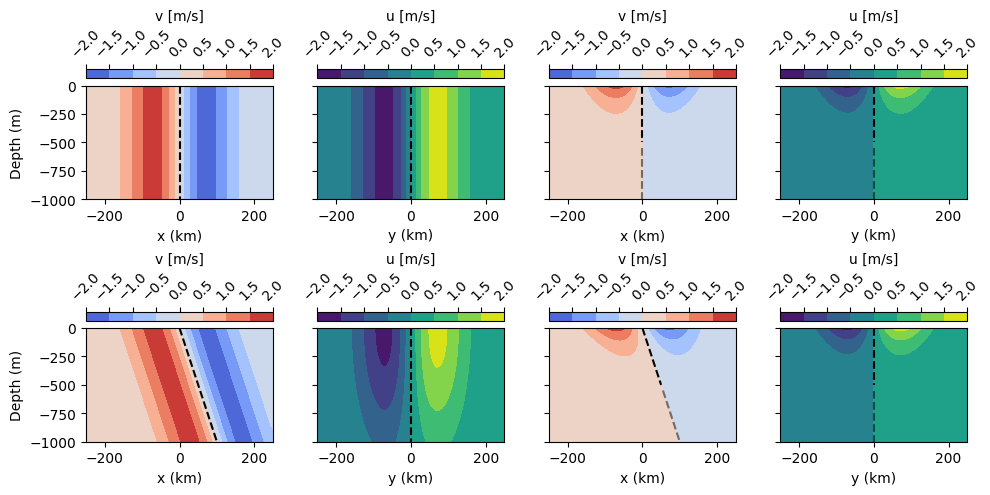

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)
x = modelled_data['x']/1000
y = modelled_data['y']/1000
for i, ax_pair in enumerate(axs.reshape(-1, 2)):
    eddy = eddies[i]
    U = modelled_data[eddy]['U'][modelled_data[eddy]['U'].shape[0] // 2, :, :]
    V = modelled_data[eddy]['V'][:, modelled_data[eddy]['V'].shape[1] // 2, :]

    im1 = ax_pair[0].contourf(x, z, V.T, cmap='coolwarm')
    im2 = ax_pair[1].contourf(y, z, U.T)

    df = result_data[result_data['Eddy'] == eddy].drop(columns='Eddy').set_index('z')

    VORT_THRESH = -0.006
    mask = df['Vort'] <= VORT_THRESH
    mask = mask.tolist()
    for i in range(len(mask) - 2, -1, -1):
        if mask[i] and not mask[i + 1]:
            mask[i + 1] = True
            break
    mask = pd.Series(mask)
    ax_pair[0].plot(df.loc[mask, 'xc'], df.loc[mask, 'Depth'], 'k', label='VG', alpha=1, linestyle='--')
    ax_pair[0].plot(df.loc[~mask, 'xc'], df.loc[~mask, 'Depth'], 'k', alpha=0.5, linestyle='--')
    ax_pair[1].plot(df.loc[mask, 'yc'], df.loc[mask, 'Depth'], 'k', label='VG', alpha=1, linestyle='--')
    ax_pair[1].plot(df.loc[~mask, 'yc'], df.loc[~mask, 'Depth'], 'k', alpha=0.5, linestyle='--')
        
    ax_pair[0].set_xlabel('x (km)')
    ax_pair[1].set_xlabel('y (km)')

    cbar1 = fig.colorbar(im1, ax=ax_pair[0], orientation='horizontal', location='top', label='v [m/s]')
    cbar2 = fig.colorbar(im2, ax=ax_pair[1], orientation='horizontal', location='top', label='u [m/s]')

    # Rotate colorbar ticks
    cbar1.ax.tick_params(axis='x', rotation=45)
    cbar2.ax.tick_params(axis='x', rotation=45)

axs[0, 0].set_ylabel('Depth (m)')
axs[1, 0].set_ylabel('Depth (m)')

plt.tight_layout()
plt.show()


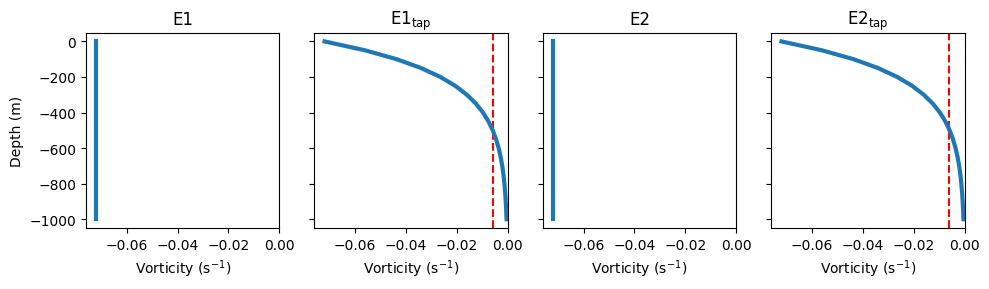

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3), sharey=True)
xmin = 0
for ax, eddy in zip(axs.flatten(), eddies):
    df = result_data[result_data['Eddy'] == eddy].drop(columns='Eddy').set_index('z')
    ax.plot(df['Vort'], df['Depth'], linewidth=3)
    ax.set_title(modelled_data[eddy]['Name'])
    xmin = min(xmin, ax.get_xlim()[0])

VORT_THRESH = -0.006
axs[1].axvline(x=VORT_THRESH, color='r', linestyle='--', zorder=0) 
axs[3].axvline(x=VORT_THRESH, color='r', linestyle='--', zorder=0) 

for ax in axs.flatten():
    ax.set_xlim(xmin, 0)
    ax.set_xlabel(r'Vorticity (s$^{-1}$)')

axs[0].set_ylabel('Depth (m)')

fig.tight_layout()
plt.show()


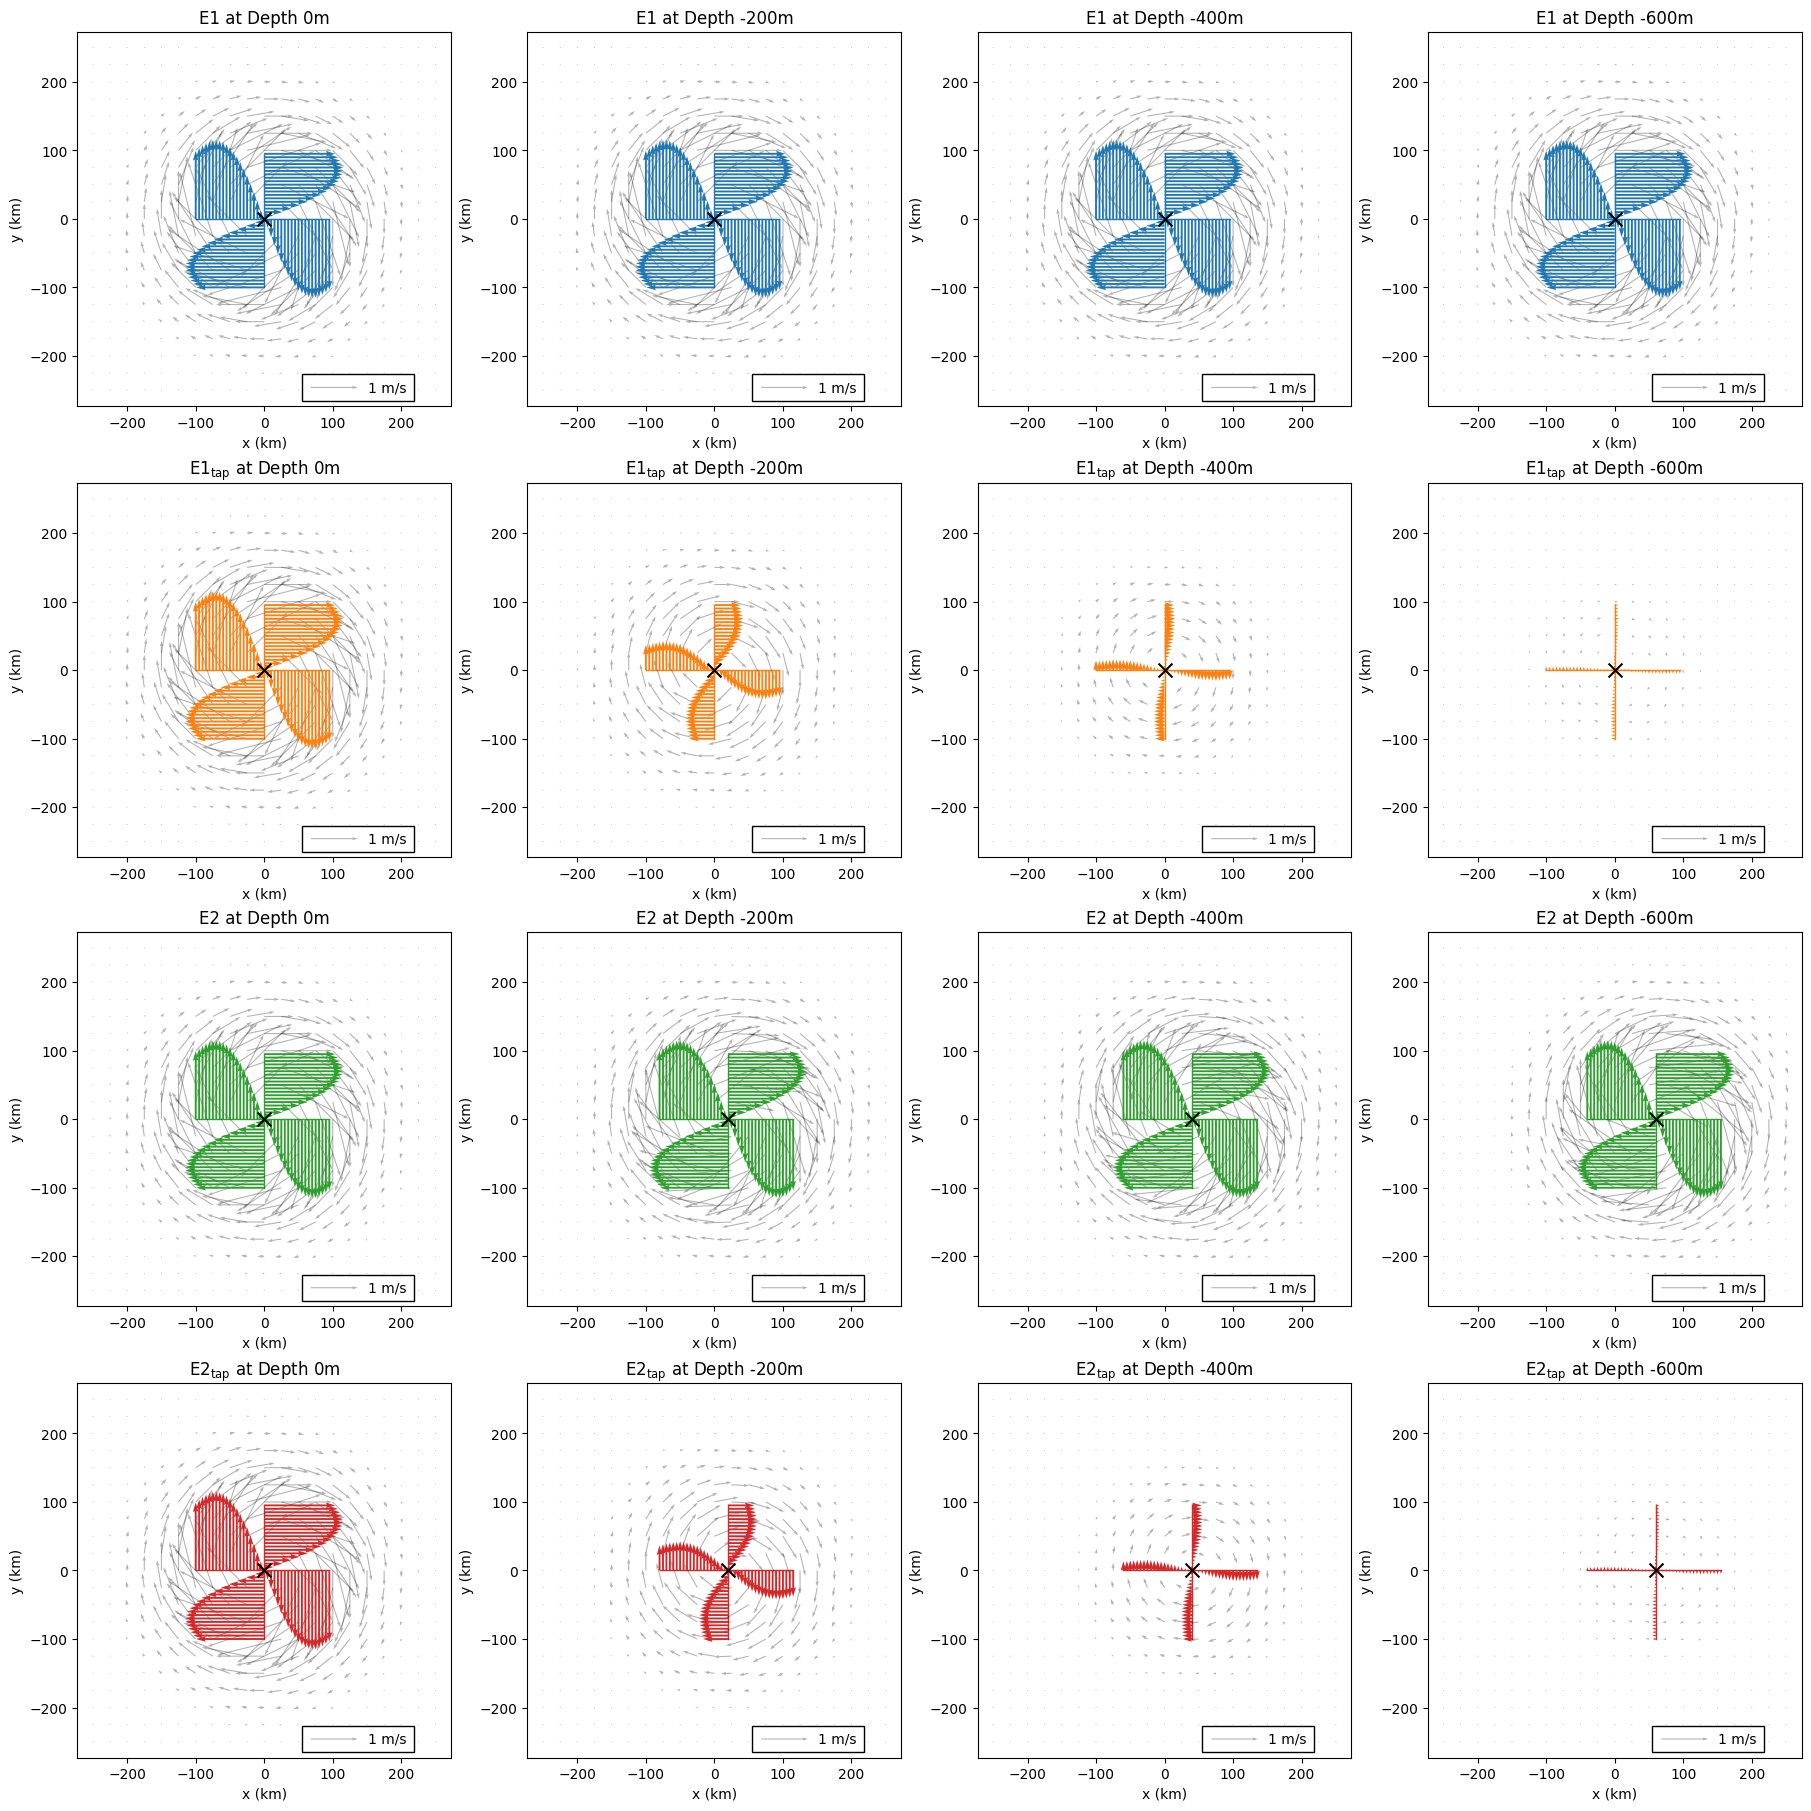

In [11]:
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(4, 4, figsize=(18, 18), constrained_layout=True)#, sharex=True, sharey=True)
for r, eddy in enumerate(eddies):
    
    depth_lvls = [0, 4, 8, 12]
    
    scale_factor = [8, 8, 8, 8]
    colors = plt.cm.tab10.colors * 3

    x = modelled_data['x']/1000
    y = modelled_data['y']/1000
    z = modelled_data['z']
    X, Y = np.meshgrid(x, y)
    
    for i, depth_lvl in enumerate(depth_lvls):
        ax = axes[r, i]
        
        u = modelled_data[eddy]['U'][:, :, depth_lvl]
        v = modelled_data[eddy]['V'][:, :, depth_lvl]

        name = modelled_data[eddy]['Name']
        
        spacing = 5
        quiv = ax.quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing],
                  u[::spacing, ::spacing].T, v[::spacing, ::spacing].T,
                  alpha=0.3, scale=scale_factor[i])
        data = result_data[result_data['Eddy'] == eddy].drop(columns='Eddy').set_index('z').loc[depth_lvl]  
        n_xc = data['nxc'] 
        n_yc = data['nyc']
        xc = data['xc'] 
        yc = data['yc'] 
        i_nenc = data['nic'] 
        j_nenc = data['njc'] 
        xx = plot_data[eddy]['x'+str(depth_lvl)]
        yy = plot_data[eddy]['y'+str(depth_lvl)]

        iu = plot_data[eddy]['u1_'+str(depth_lvl)]
        iv = plot_data[eddy]['v1_'+str(depth_lvl)]
        ju = plot_data[eddy]['u2_'+str(depth_lvl)]
        jv = plot_data[eddy]['v2_'+str(depth_lvl)]
        
        spacing = 1
        ax.quiver(xx[::spacing], [n_yc] * len(xx[::spacing]),
                  iu[::spacing], iv[::spacing], color=colors[r], scale=scale_factor[i], width=0.005)
        ax.quiver([n_xc] * len(yy[::spacing]), yy[::spacing],
                  ju[::spacing], jv[::spacing], color=colors[r], scale=scale_factor[i], width=0.005)
        ax.plot(xx, [n_yc] * len(xx), zorder=0, linewidth=1, color=colors[r])
        ax.plot([n_xc] * len(yy), yy, zorder=0, linewidth=1, color=colors[r])
        ax.scatter(xc, yc, marker='x', s=100, color='k')
        
        ax.set_xlabel('x (km)')
        ax.set_ylabel('y (km)')
        ax.set_title(name+' at Depth '+str(round(z[depth_lvl]))+'m')

        if np.any(np.isnan(u)) and r != 1:
            nan_mask = np.isnan(u)
            mask = np.where(~np.isnan(u), np.nan, 0)
            ax.contourf(x, y, mask.T, cmap='gray', zorder=-1)
            ax.contour(x, y, nan_mask.T, colors='k', linewidths=2, alpha=.5)

        magnitude = 1
        x_pos, y_pos = 0.75, 0.05  
        box_width = 0.3  # Adjust width as needed
        box_height = 0.07  # Adjust height as needed
        rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                               box_width, box_height, transform=ax.transAxes,
                               facecolor='white', edgecolor='black')
        ax.add_patch(rect)
        ax.quiverkey(quiv, X=x_pos, Y=y_pos, U=magnitude,
                     label=f'{magnitude} m/s', labelpos='E')
        ax.axis('equal')
        
plt.show()

In [12]:
def vis(eddy, depth_lvl):
    
    x, y = modelled_data['x'], modelled_data['y']
    dx = x[1] - x[0]
    X, Y = np.meshgrid(x, y)
    var = 1
    
    U, V = modelled_data[eddy]['U'], modelled_data[eddy]['V']
    
    # Find nencioli
    u, v = U[:, :, depth_lvl], V[:, :, depth_lvl]
    neddy = nencioli(u.T, v.T, X, Y, 4, 3)[2]
    neddy = neddy[neddy[:, 2] == var]
    
    if len(neddy[:, 1]) > 1:
        R = np.hypot(xc_pre - neddy[:, 1], yc_pre - neddy[:, 0])
        neddy = neddy[R == np.nanmin(R)]
    elif len(neddy[:, 1]) == 0:
        raise ValueError("Error: Nencioli failed to find eddy center.")
    
    nxc = neddy[0, 1] #+ 25000
    nyc = neddy[0, 0] #+ 25000
    nic, njc = np.where(nxc == x)[0][0], np.where(nyc == y)[0][0]
    
    # Fit cubic and tangent
    def fit_cubic_and_tangent(x, y):
        cubic = np.poly1d(np.polyfit(x, y, 3))
        cubic_deriv = np.polyder(cubic)
        roots = np.roots(cubic)
        valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
    
        if valid_roots.size:
            R = np.abs(valid_roots-x[len(x)//2])
            root = valid_roots[R==np.min(R)][0]
            slope = cubic_deriv(root)
            intercept = -slope * root
        else:
            slope = 0
            roots = np.roots(cubic_deriv)
            valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
            if valid_roots.size:
                R = np.abs(valid_roots-x[len(x)//2])
                root = valid_roots[R==np.min(R)]
                intercept = cubic(root)
            else:
                intercept = np.mean(y)
    
        sst = np.sum((y - np.mean(y))**2)
        sse = np.sum((y - cubic(x))**2)  # Use cubic(x) instead of tangent_line

        r_squared = 1 if (sst == 0 and sse == 0) else 1 - (sse / sst)
            
        return slope, intercept, r_squared

    def optimal_cubic_domain(l, vel, ic, r_min=20, r_max=30):

        def min_distance_from_index_to_nan_1d(arr, ic):
            from scipy.ndimage import distance_transform_edt
            mask = np.isnan(arr)
            distances = distance_transform_edt(~mask)
            return int(distances[ic] - 1)
            
        r_compulsory_min = min_distance_from_index_to_nan_1d(vel, ic)

        if r_compulsory_min < r_min:
            if r_compulsory_min > 3:
                r_min = r_compulsory_min
            else:
                return None, None, None, None, None

        results = []
    
        for r1 in range(r_min, r_max + 1):
            for r2 in range(r_min, r_max + 1):
                i_min, i_max = max(0, ic - r1), min(len(vel), ic + r2 + 1)
    
                vel_cut = vel[i_min:i_max]
                l_cut = l[i_min:i_max]
                if np.any(np.isnan(vel_cut)): # another r will work
                    E1, E0, r2E = np.nan, np.nan, np.nan
                else:
                    mask = ~np.isnan(vel_cut)
                    vel_cut = vel_cut[mask]
                    l_cut = l_cut[mask] / 1000

                    E1, E0, r2E = fit_cubic_and_tangent(l_cut, vel_cut)
        
                results.append((r1, r2, E1, E0, r2E))
    
        df = pd.DataFrame(results, columns=['r1', 'r2', 'Slope', 'Int', 'R2'])

        if df.isna().all().all():
            return None, None, None, None, None
    
        optimal_domain = df.loc[df['R2']==np.nanmax(df['R2'])].iloc[-1]

        return optimal_domain['Slope'], optimal_domain['Int'], optimal_domain['R2'], optimal_domain['r1'], optimal_domain['r2']

    u1, v1 = u[:, njc], v[:, njc]
    u2, v2 = u[nic, :], v[nic, :]

    B1, B0, r2B, r1, r2 = optimal_cubic_domain(x, v1, nic)
    C1, C0, r2C, r3, r4 = optimal_cubic_domain(y, u2, njc)

    i_min, i_max = int(max(0, nic - r1)), int(min(len(u1), nic + r2))
    u1, v1 = u1[i_min:i_max], v1[i_min:i_max]
    xx = x[i_min:i_max]/1000
    A1, A0, r2A = fit_cubic_and_tangent(xx, u1)

    j_min, j_max = int(max(0, njc - r3)), int(min(len(u2), njc + r4))
    u2, v2 = u2[j_min:j_max], v2[j_min:j_max]
    yy = y[j_min:j_max]/1000
    D1, D0, r2D = fit_cubic_and_tangent(yy, v2)


    fig, axs = plt.subplots(1, 4, figsize=(28, 7))
    datasets = [(xx, u1, 'u1'),
                (xx, v1, 'v1'),
                (yy, u2, 'u2'),
                (yy, v2, 'v2')]
    
    for ax, (l, vel, label) in zip(axs, datasets):
        slope, intercept, R2 = fit_cubic_and_tangent(l, vel)
        l_fine = np.linspace(l.min(), l.max(), 500)
        ax.plot(l, vel, 'o', label=f'Original {label} data')
        ax.plot(l_fine, np.poly1d(np.polyfit(l, vel, 3))(l_fine), '-', label=f'Cubic fit for {label}')
        ax.plot(l_fine, slope * l_fine + intercept, '--', label=f'R2={R2:.2f}')
        ax.axhline(0, color='k', linestyle='-', linewidth=0.5, alpha=.5)
        ax.set_xlabel('x' if '1' in label else 'y')
        ax.set_ylabel(label)
        ax.legend()
    plt.tight_layout()
    plt.show()
                
    # Calculate results
    A1, A0, r2A = fit_cubic_and_tangent(xx, u1)
    B1, B0, r2B = fit_cubic_and_tangent(xx, v1)
    C1, C0, r2C = fit_cubic_and_tangent(yy, u2)
    D1, D0, r2D = fit_cubic_and_tangent(yy, v2)
    
    alpha = A0 if r2A < r2B else C0
    beta = B0 if r2B < r2D else D0
    gamma = A1 if r2A < r2D else -D1
    q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
                
    yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))
    xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))
    w = 2 * (q11 + q22)

    # Plot results
    spacing = 5
    plt.quiver(X[::spacing, ::spacing]/1000, Y[::spacing, ::spacing]/1000, u[::spacing, ::spacing].T, v[::spacing, ::spacing].T)

    plt.plot(xx, [nyc/1000] *len(xx), 'r', zorder=1, alpha=.5)
    plt.plot([nxc/1000] * len(yy), yy, 'r', zorder=1, alpha=.5)

    if np.any(np.isnan(u)):
        nan_mask = np.isnan(u)
        mask = np.where(~np.isnan(u), np.nan, 0)
        plt.contourf(X/1000, Y/1000, mask.T, cmap='gray', zorder=-1)
        plt.contour(X/1000, Y/1000, nan_mask.T, colors='k', linewidths=2, alpha=.5)

    # plt.scatter(nxc/1000, nyc/1000, color='k', marker='x', label='Nenc')
    plt.scatter(xc, yc, color='r', marker='x', s=100, label='MOCA')
    plt.legend()

    print(f'r1={r1*dx/1000}km, r2={r2*dx/1000}km, r3={r3*dx/1000}km, r4={r4*dx/1000}km, vorticity={round(w,3)} 1/s, Depth={round(z[depth_lvl])}m')
    

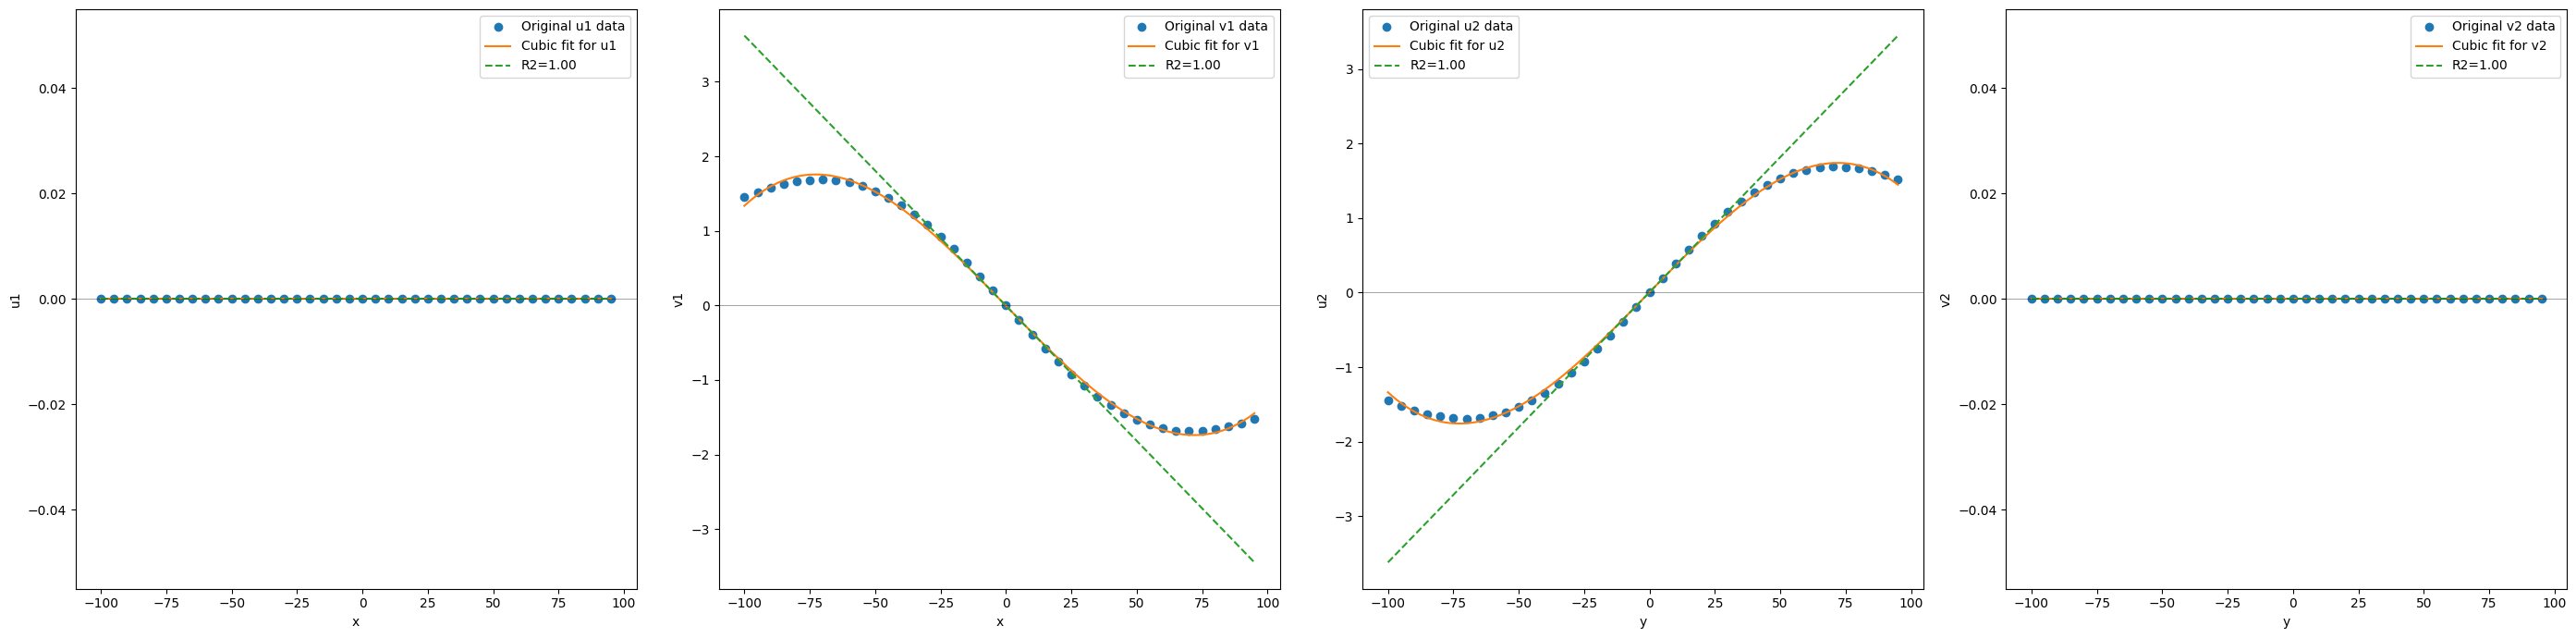

r1=100.0km, r2=100.0km, r3=100.0km, r4=100.0km, vorticity=-0.072 1/s, Depth=0m


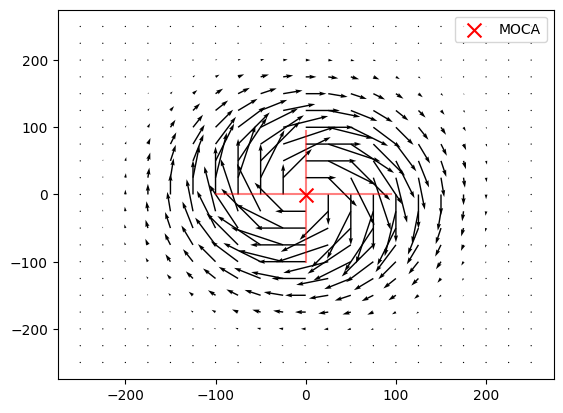

In [13]:
vis('Eddy2', 0)

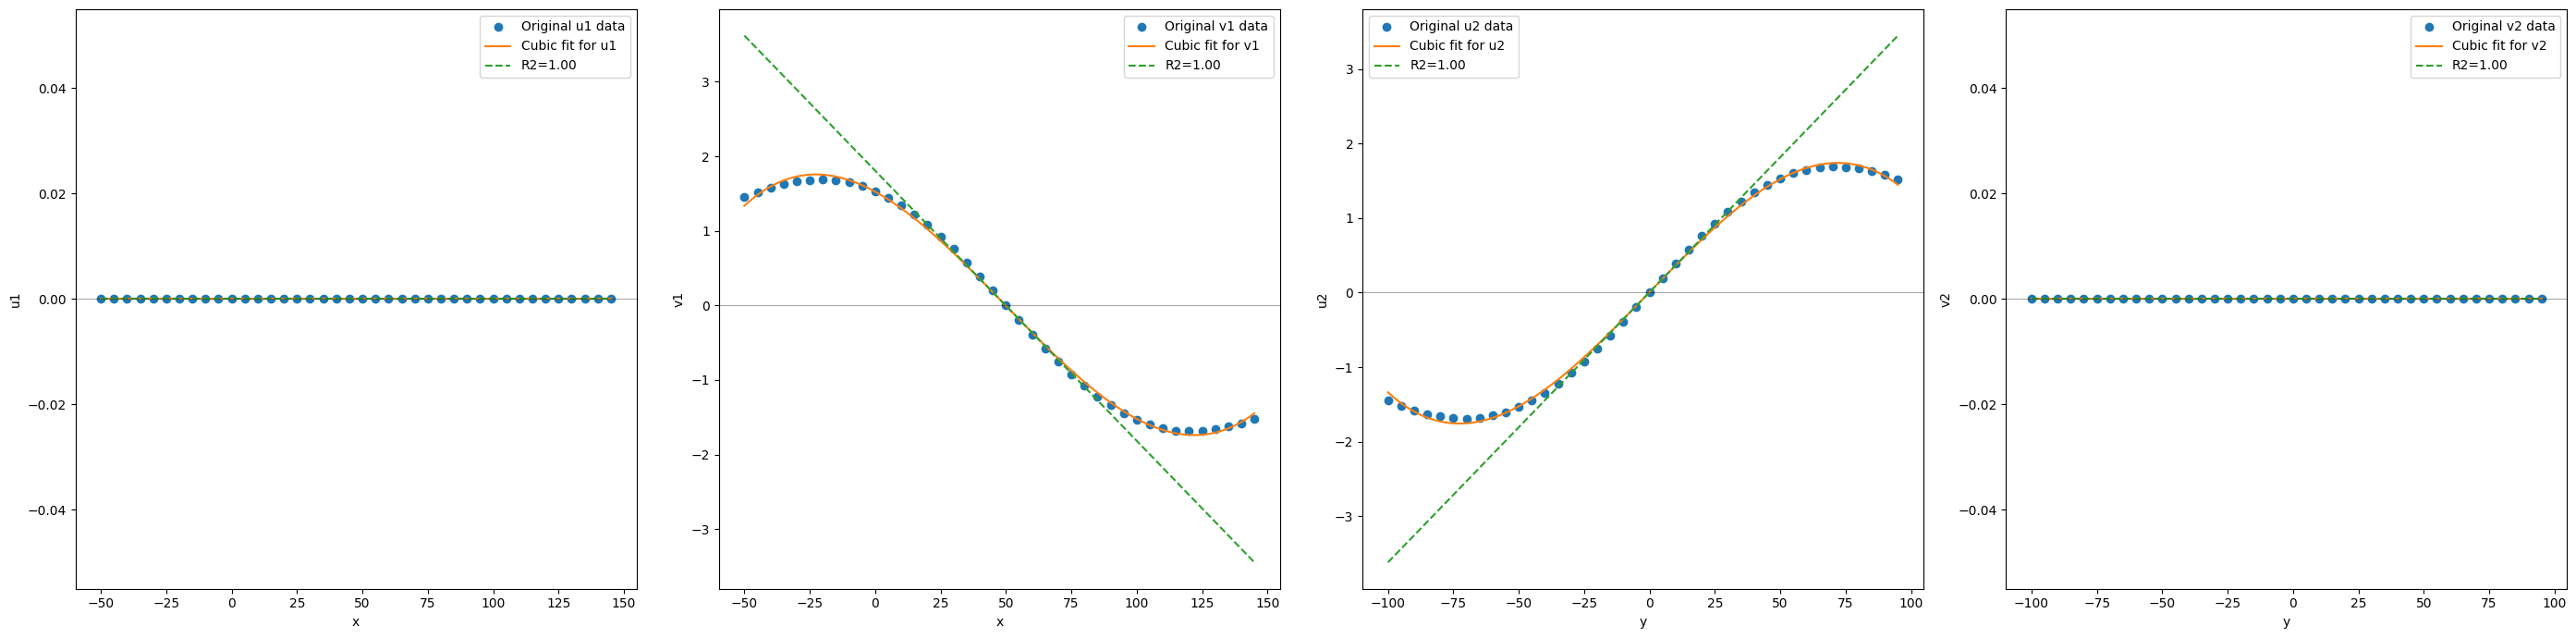

r1=100.0km, r2=100.0km, r3=100.0km, r4=100.0km, vorticity=-0.072 1/s, Depth=-500m


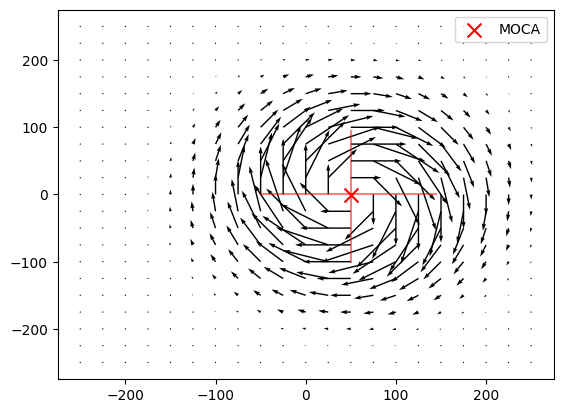

In [14]:
vis('Eddy2', 10)

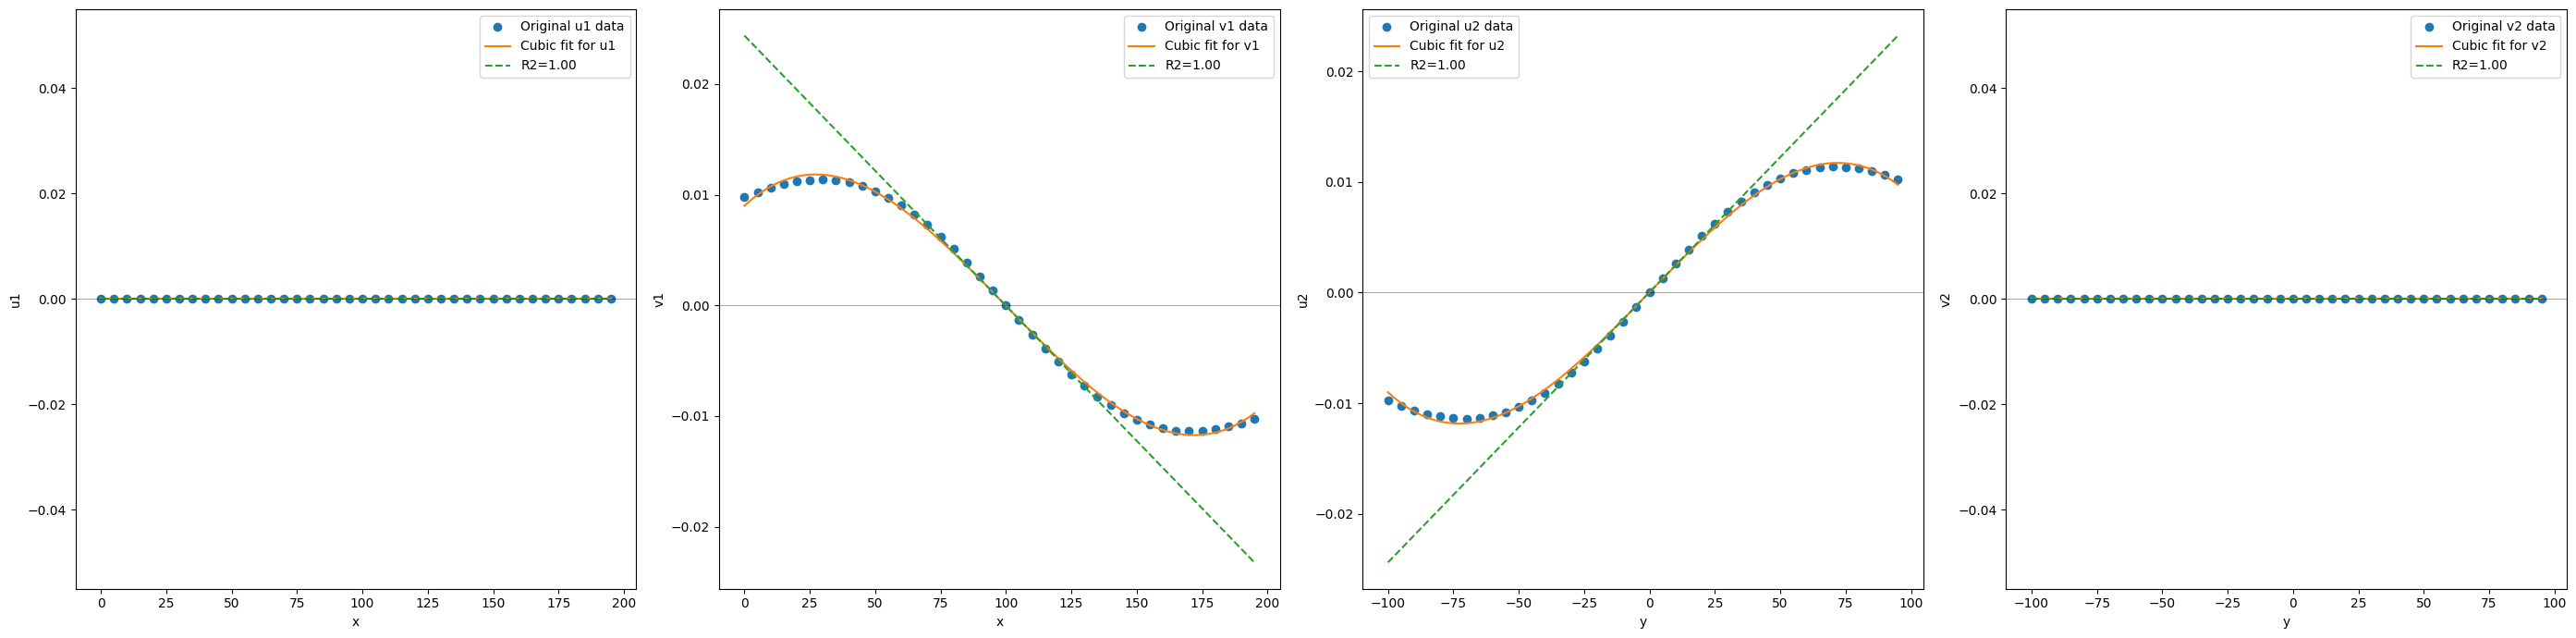

r1=100.0km, r2=100.0km, r3=100.0km, r4=100.0km, vorticity=-0.0 1/s, Depth=-1000m


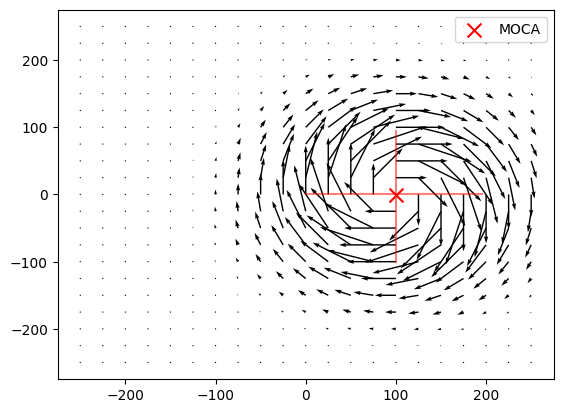

In [15]:
vis('Eddy3', 20)

## OFF CENTER

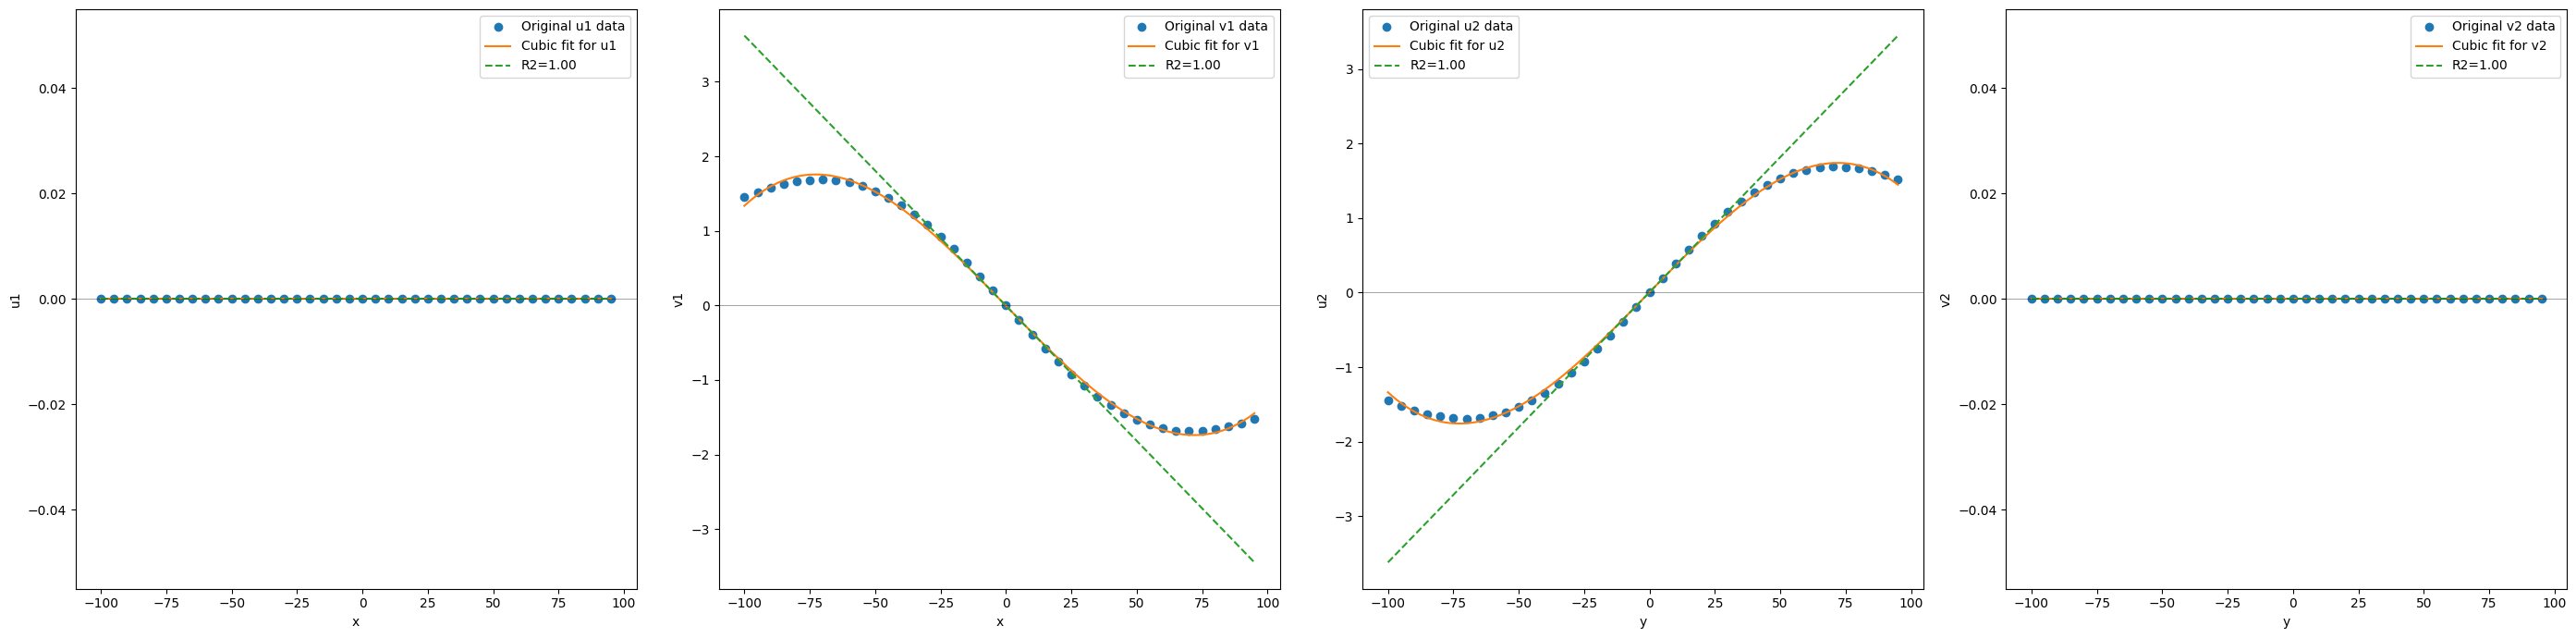

r1=100.0km, r2=100.0km, r3=100.0km, r4=100.0km, vorticity=-0.072 1/s, Depth=0m


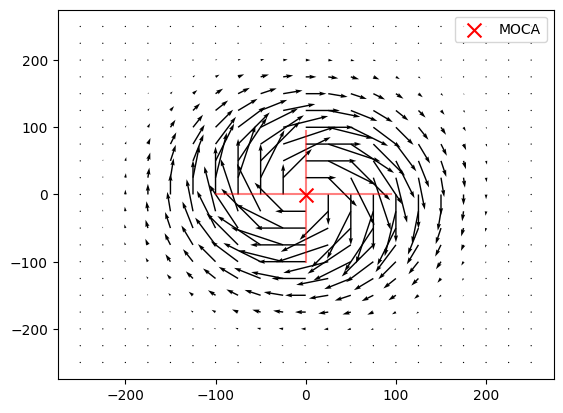

In [16]:
vis('Eddy2', 0)

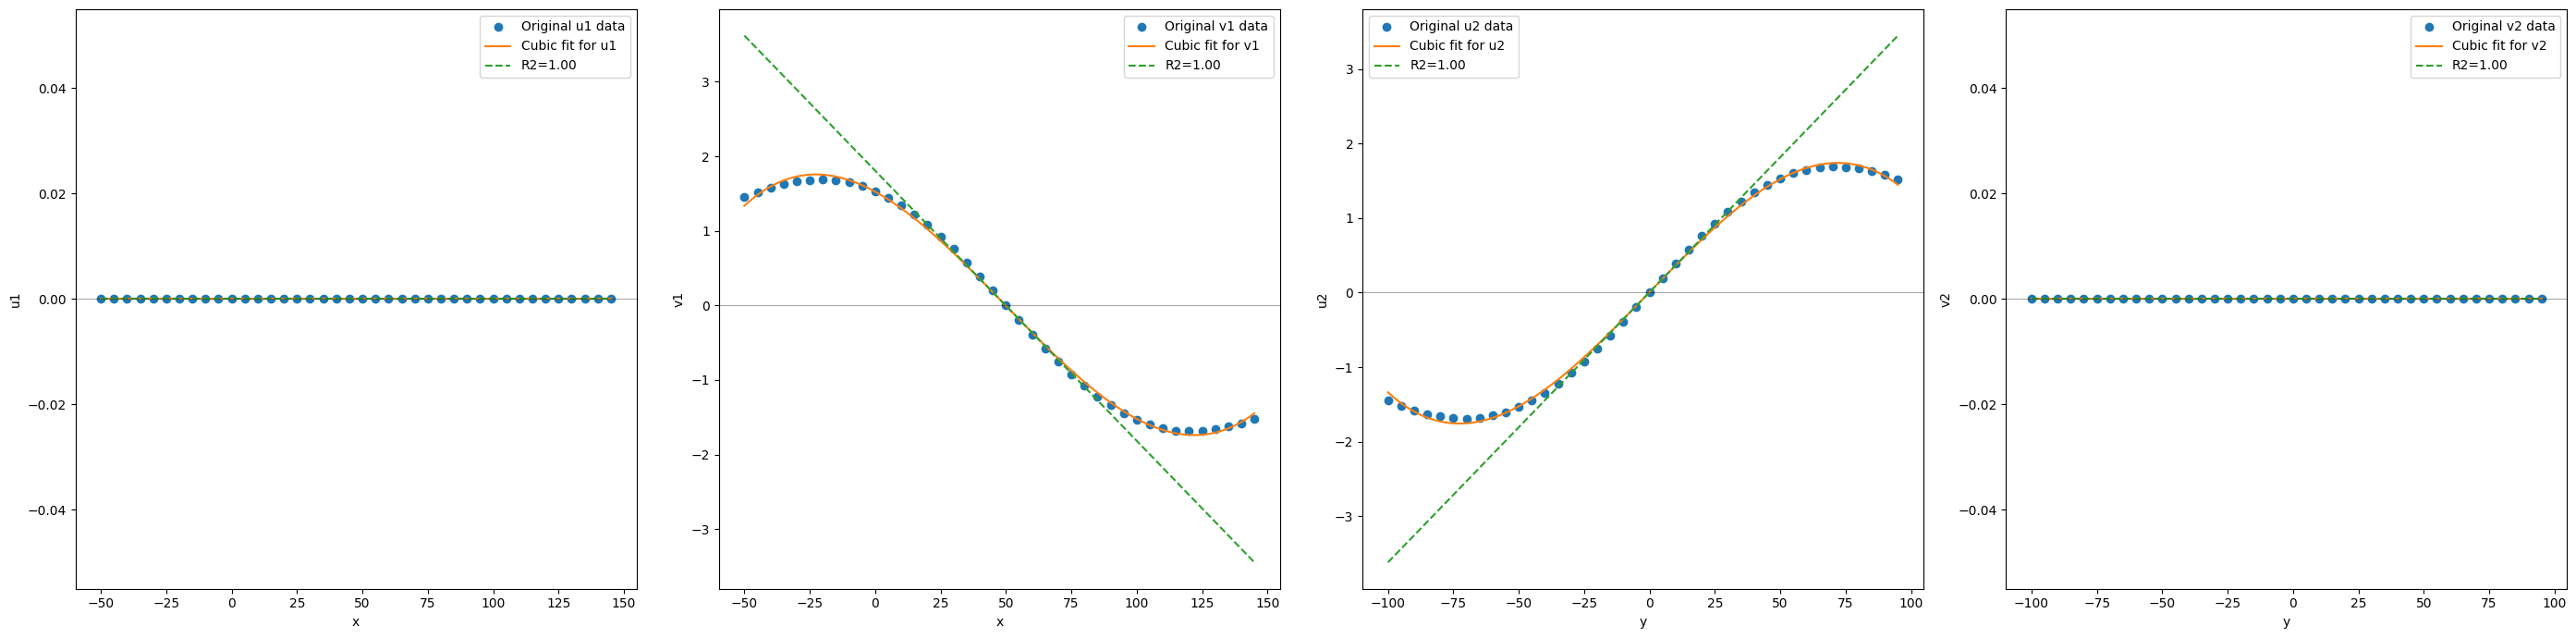

r1=100.0km, r2=100.0km, r3=100.0km, r4=100.0km, vorticity=-0.072 1/s, Depth=-500m


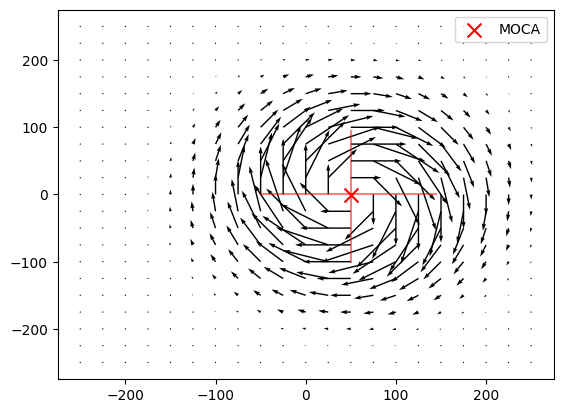

In [17]:
vis('Eddy2', 10)

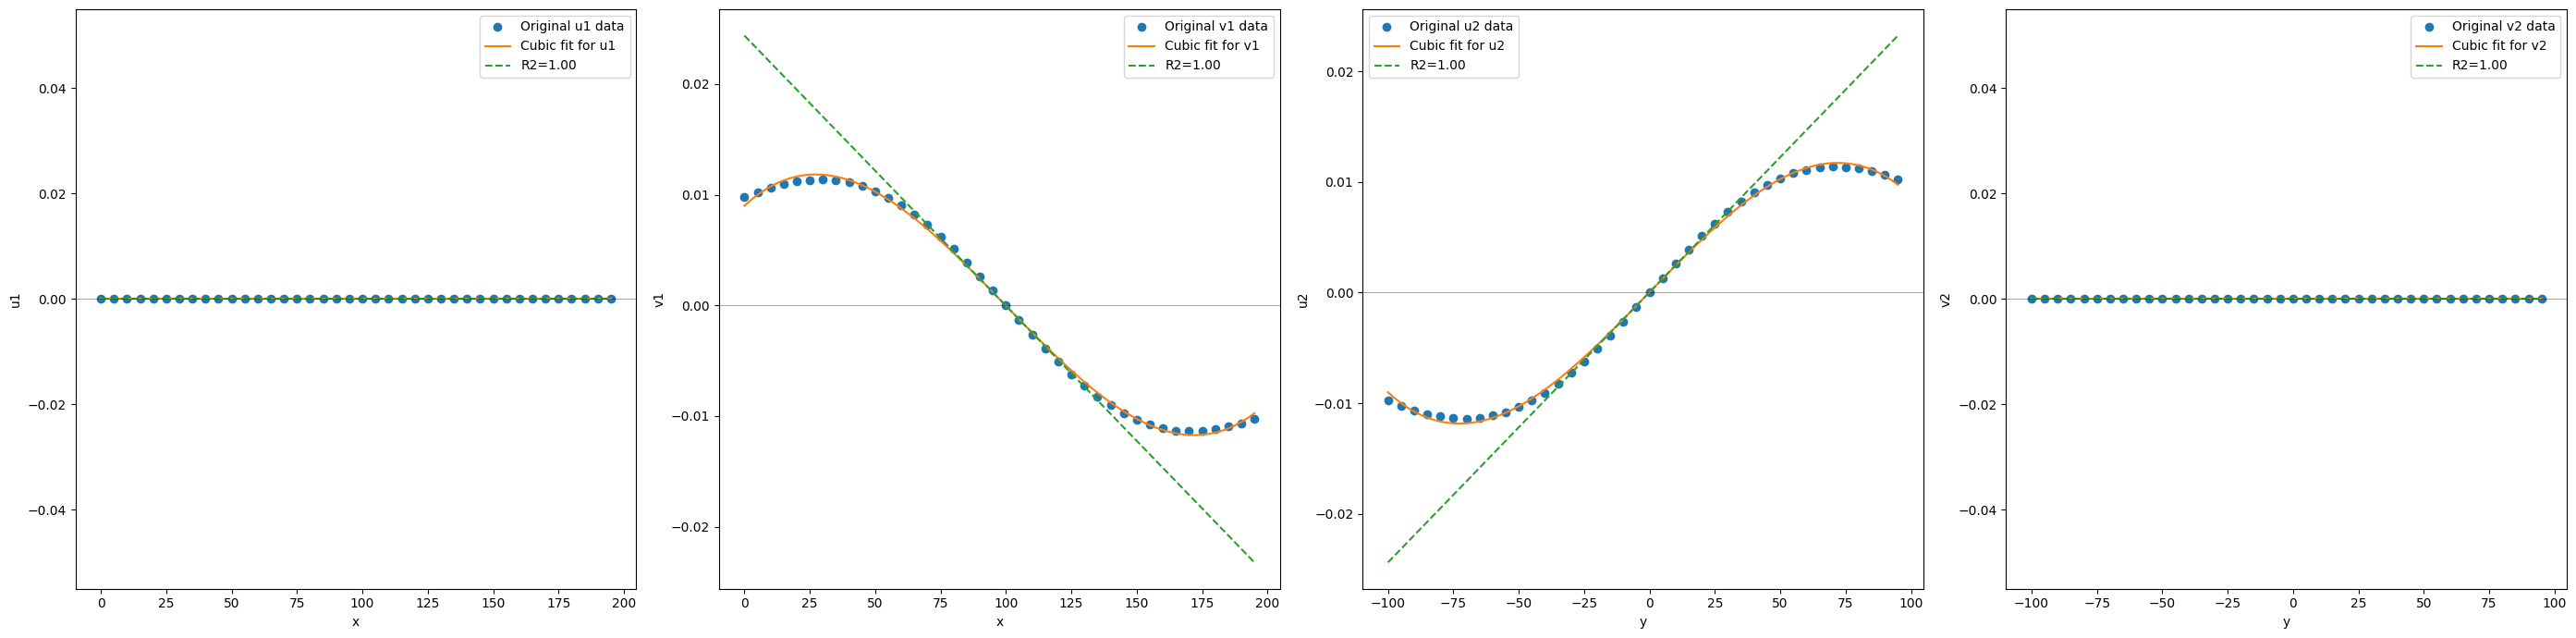

r1=100.0km, r2=100.0km, r3=100.0km, r4=100.0km, vorticity=-0.0 1/s, Depth=-1000m


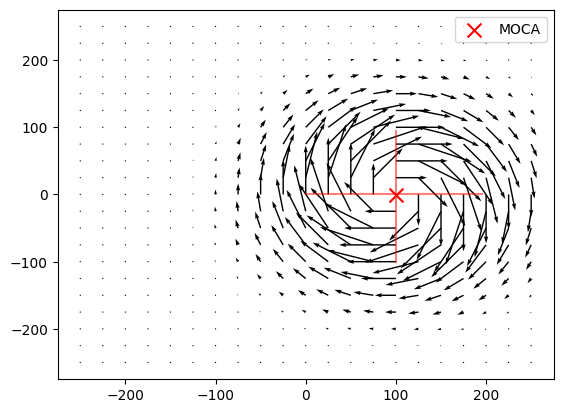

In [18]:
vis('Eddy3', 20)